In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_percentage_error

import optuna
import matplotlib.pyplot as plt
import japanize_matplotlib

# メーカーデータの足切り

In [3]:
#データの読み込み
train_data = pd.read_csv("../data/機械学習用/train_data.csv",index_col=0)
model_data = pd.read_csv('../data/アップロード用/model_data.csv',index_col=0)
info_data = pd.read_csv('../data/アップロード用/bike_info.csv',index_col=0)
#サンプルサイズが少ないモデルを抽出
all_data = info_data.merge(model_data,on='model_number',how='left')
brand_count = all_data.groupby('brand').size().sort_values(ascending=True)
#下位10メーカーを抽出(上のcountデータがすでに照準のため上から９つを抽出する)
low_10 = brand_count.index[0:10]
model_data = model_data[~model_data['brand'].isin(low_10)]
#このメーカーデータを使ってtrainデータに結合
train_data = train_data.merge(model_data,on='model_number',how='left')
#先ほど外れ値に指定したデータはnullになるため、dropnaをすればok
train_data.dropna(inplace=True)

# モデルの作成  
使用する特徴量  
* model_year
* color
* mileage 
* gurantee_period
* brand
* type
* displacement  
今回、最終的にはwebアプリ化を目標としているためstore_idは削除,model_number,nameはデータがないバイクが予測時に取り扱えなくなるので削除した

In [4]:
#dummyエンコーディング
encoding_target = ['color','brand','type']
#エンコーディングしたい列
train_data=pd.get_dummies(train_data,drop_first=True,columns=encoding_target)

In [5]:
#説明変数と目的変数の抽出
X = train_data.iloc[:,2:].drop(columns=['model_number','name','store_id'])
y = train_data['cost']
#学習データと検証データへの分割
X_learn,X_val,y_learn,y_val = train_test_split(X,y,test_size=0.2,random_state=123)

# OptunaとCVを組み合わせたパラメータチューニング

# MAPEを指標としたモデルのチューニング

In [6]:
# def objective(trial):
#     model = RandomForestRegressor(random_state=0)
#     params = {
#         'bootstrap':trial.suggest_categorical('bootstrap',[True,False]),
#         'max_depth':trial.suggest_int('max_depth',1,100),
#         'max_features':trial.suggest_float('max_features',0,1.0),
#         'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',2,1000),
#         'n_estimators':trial.suggest_int('n_estimators',1,1000),
#         'min_samples_split':trial.suggest_int('min_samples_split',2,5),
#         'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10)
#     }
#     reg_model=model.set_params(**params)

#     #スコアをcross_val_scoreにする(cv=5,scoring=r2_score)
#     score = cross_val_score(reg_model,X_learn,y_learn,cv=5,scoring='neg_mean_absolute_percentage_error',n_jobs=-1)

#     mape = score.mean()

#     return mape

In [7]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective,n_trials=100)

In [8]:
best_params={'bootstrap': False,
             'max_depth': 28,
             'max_features': 0.5316817512634053,
             'max_leaf_nodes': 864,
             'n_estimators': 378,
             'min_samples_split': 4,
             'min_samples_leaf': 1}

# チューニングしたモデルの実装

In [9]:
rf = RandomForestRegressor(random_state=0)
rf.set_params(**best_params)
rf.fit(X_learn,y_learn)

RandomForestRegressor(bootstrap=False, max_depth=28,
                      max_features=0.5316817512634053, max_leaf_nodes=864,
                      min_samples_split=4, n_estimators=378, random_state=0)

In [10]:
predict_learn = rf.predict(X_learn)
predict_val = rf.predict(X_val)
print('学習データMAPE',mean_absolute_percentage_error(y_pred=predict_learn,y_true=y_learn))
print('検証データMAPE',mean_absolute_percentage_error(y_pred=predict_val,y_true=y_val))
print('学習データr_2',rf.score(X_learn,y_learn))
print('検証データr_2',rf.score(X_val,y_val))

学習データMAPE 0.061575957802362545
検証データMAPE 0.14702616312368091
学習データr_2 0.9835950298167148
検証データr_2 0.8101697607731079


In [11]:
rf.score(X_val,y_val)

0.8101697607731079

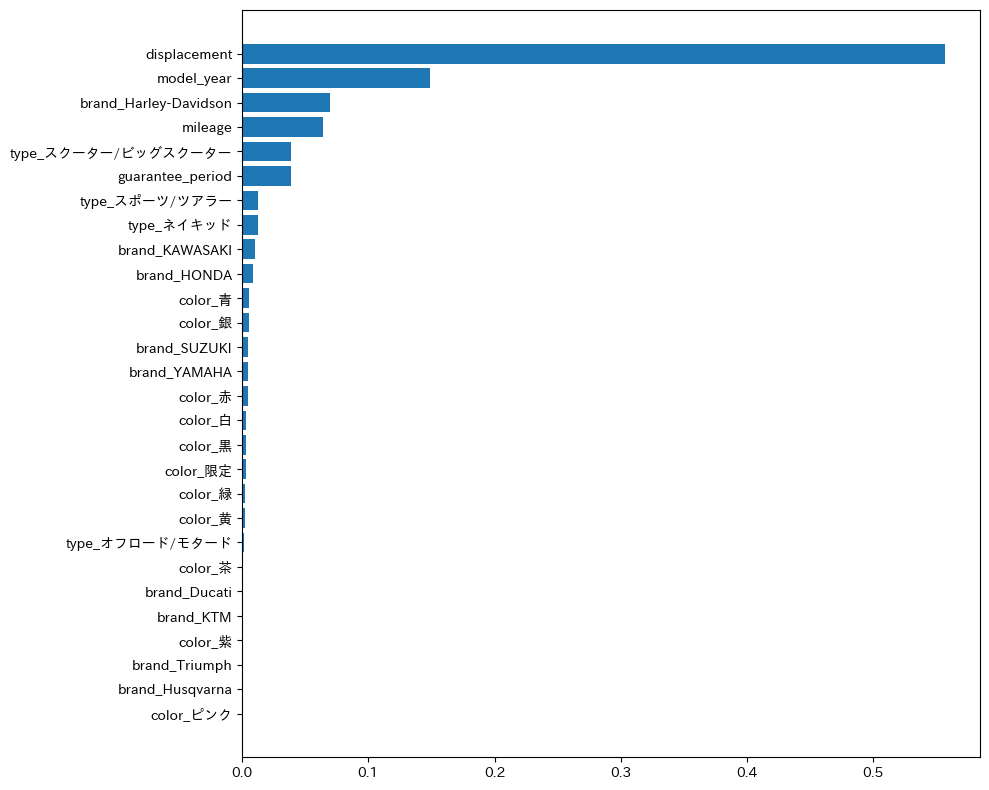

In [12]:
#feature_importanceも確認してみる
plt.subplots(figsize=(10,8))
featuer_name = train_data.drop(columns=['id','cost','model_number','name','store_id']).columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.barh(np.asarray(featuer_name)[indices],importances[indices])
plt.tight_layout()
plt.show()

# 残差プロットを作成

In [13]:
y_learn_pred = rf.predict(X_learn)
y_val_pred = rf.predict(X_val)

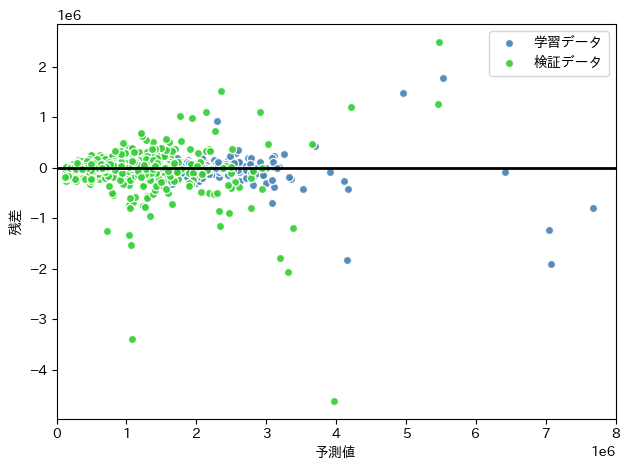

In [14]:
plt.scatter(y_learn_pred,
            y_learn_pred - y_learn,
            c='steelblue',
            edgecolors='white',
            marker='o',
            s=35,
            alpha=0.9,
            label = '学習データ')
plt.scatter(y_val_pred,
            y_val_pred - y_val,
            c='limegreen',
            edgecolors='white',
            marker='o',
            s=35,
            alpha=0.9,
            label ='検証データ')
plt.xlabel('予測値')
plt.ylabel('残差')
plt.legend()
plt.hlines(y=0,xmin=-10,xmax=8*10**6,lw=2,colors='black')
plt.xlim([-10,8*10**6])
plt.tight_layout()
plt.show()

# テストデータ検証

In [15]:
test_data = pd.read_csv('../data/機械学習用/test_data.csv',index_col=0)
test_data=test_data.merge(model_data,on='model_number',how='left')
test_data.dropna(inplace=True)
#ダミー変数化
#dummyエンコーディング
encoding_target = ['color','brand','type']
#エンコーディングしたい列
test_data=pd.get_dummies(test_data,drop_first=True,columns=encoding_target)
X_test=test_data.iloc[:,2:].drop(columns=['name','model_number','store_id'])
y_test = test_data['cost']

In [16]:
rf_test = RandomForestRegressor(random_state=0)
rf_test.set_params(**best_params)
rf_test.fit(X,y)
predict_train = rf_test.predict(X)
predict_test = rf_test.predict(X_test)
print('訓練データ決定係数',r2_score(y_true=y,y_pred=predict_train))
print('テストデータ決定係数',r2_score(y_true=y_test,y_pred=predict_test))
print('訓練データMAPE',mean_absolute_percentage_error(y_true=y,y_pred=predict_train))
print('テストデータMAPE',mean_absolute_percentage_error(y_true=y_test,y_pred=predict_test))

訓練データ決定係数 0.9872199170655993
テストデータ決定係数 0.8133540302899638
訓練データMAPE 0.07061028635712713
テストデータMAPE 0.1379489765815342


## RandomForestによる予測がMAPEが最小,R^2スコアが最大となった

### flaskアプリ化を行うために、モデルをpickleファイルに保管

In [17]:
#もったいないのでtestデータも学習させたpicklefile化
X_all = pd.concat([X,X_test],axis=0)
y_all = pd.concat([y,y_test],axis=0)
rf_all = RandomForestRegressor(random_state=0)
rf_all.set_params(**best_params)
rf_all.fit(X_all,y_all)
predict_all = rf_all.predict(X_all)
print('訓練データ決定係数',r2_score(y_true=y_all,y_pred=predict_all))
print('訓練データMAPE',mean_absolute_percentage_error(y_true=y_all,y_pred=predict_all))

訓練データ決定係数 0.9879478788446135
訓練データMAPE 0.078188711541974


# SHAPの実装 

In [18]:
import shap

In [19]:
X_all

,model_year,mileage,guarantee_period,displacement,color_ピンク,color_白,color_紫,color_緑,color_茶,color_赤,...,brand_Husqvarna,brand_KAWASAKI,brand_KTM,brand_SUZUKI,brand_Triumph,brand_YAMAHA,type_オフロード/モタード,type_スクーター/ビッグスクーター,type_スポーツ/ツアラー,type_ネイキッド
0,2012.0,2742.0,0.25,50.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,2019.0,776.0,5.00,400.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2013.0,11979.0,1.00,250.0,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
3,2021.0,5688.0,5.00,250.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,2019.0,27167.0,1.00,250.0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,2016.0,4610.0,0.25,50.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1118,2017.0,12514.0,3.00,250.0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
1119,2022.0,1446.0,7.00,1300.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
1120,2007.0,2506.0,0.25,400.0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True


In [20]:
X_all = X_all * 1

In [21]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5600 entries, 0 to 1121
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   model_year             5600 non-null   float64
 1   mileage                5600 non-null   float64
 2   guarantee_period       5600 non-null   float64
 3   displacement           5600 non-null   float64
 4   color_ピンク              5600 non-null   int64  
 5   color_白                5600 non-null   int64  
 6   color_紫                5600 non-null   int64  
 7   color_緑                5600 non-null   int64  
 8   color_茶                5600 non-null   int64  
 9   color_赤                5600 non-null   int64  
 10  color_銀                5600 non-null   int64  
 11  color_限定               5600 non-null   int64  
 12  color_青                5600 non-null   int64  
 13  color_黄                5600 non-null   int64  
 14  color_黒                5600 non-null   int64  
 15  brand_Duc

In [22]:
#SHAP値を計算するexplainerを作成
explainer = shap.TreeExplainer(model=rf_all,
                               data = X_all,
                               feature_perturbation='interventional')

In [23]:
shap_values = explainer(X_all)

100%|===================| 5588/5600 [05:38<00:00]        

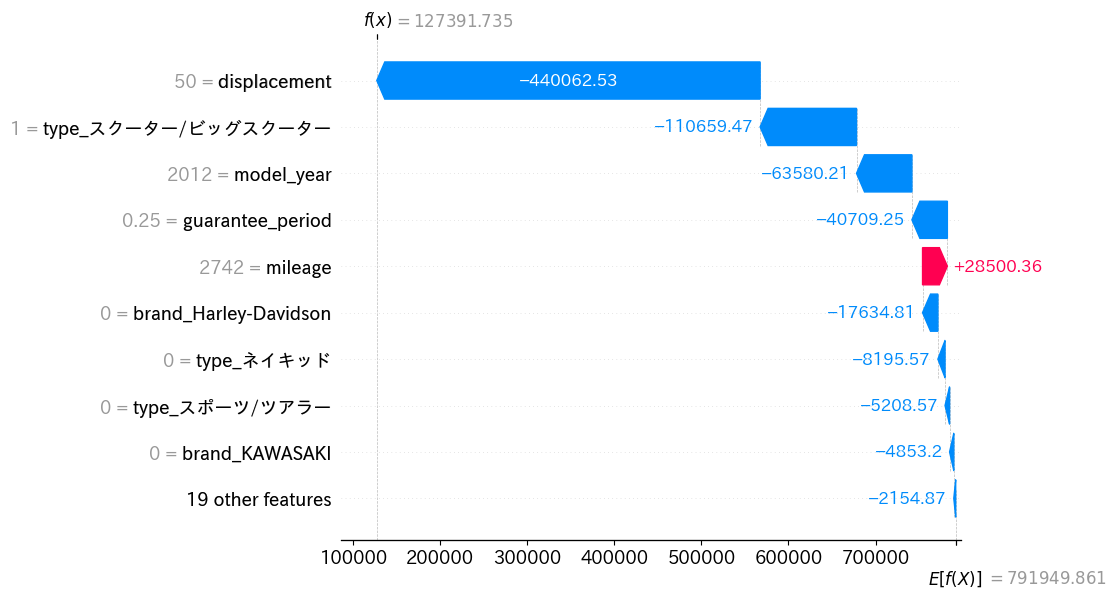

In [24]:
shap.plots.waterfall(shap_values[0])

In [25]:
rf_all.predict(X_all)

array([ 127391.75070808, 1348569.01275579,  379091.78707432, ...,
       2108267.46895467,  588974.83720966,  744248.097226  ])

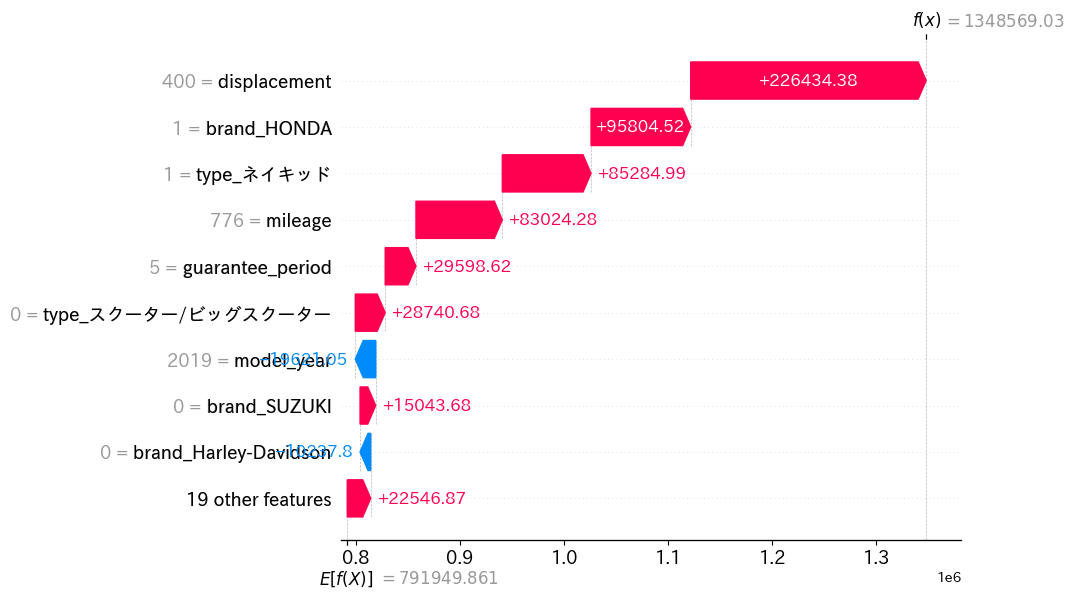

In [26]:
shap.plots.waterfall(shap_values[1])

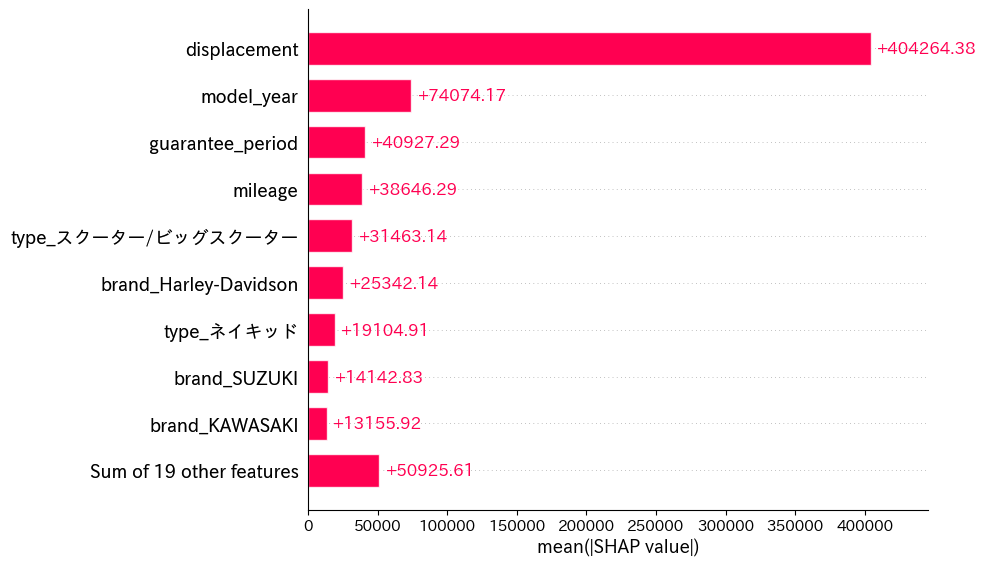

In [27]:
shap.plots.bar(shap_values=shap_values)

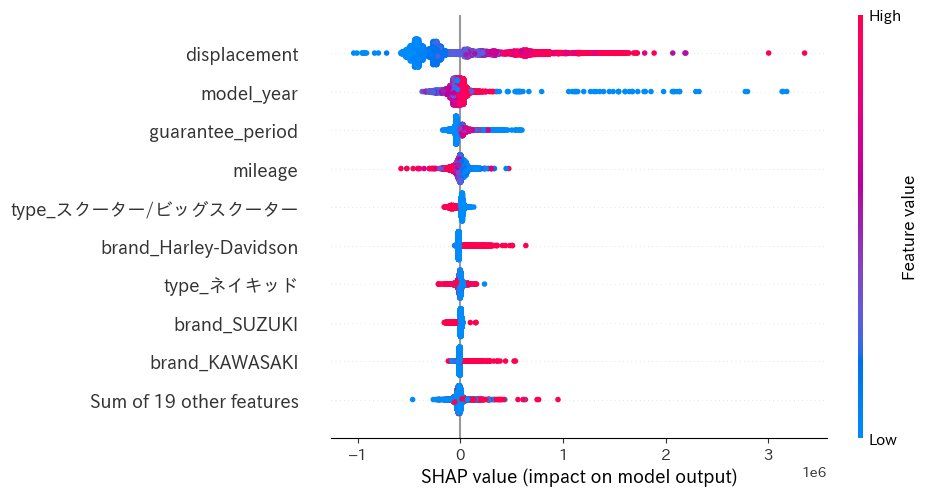

In [28]:
#beeswarm plotを重要度を可視化
shap.plots.beeswarm(shap_values)

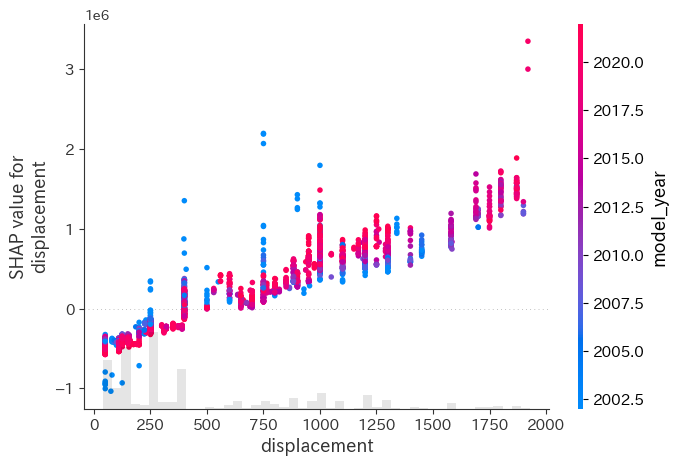

In [29]:
#SHAPによるPDを可視化
shap.plots.scatter(shap_values[:,'displacement'],color=shap_values)

In [30]:
# import pickle
# import os 
# dest = os.path.join('../flask')
# if not os.path.exists(dest):
#     os.makedirs(dest)
# pickle.dump(
#     rf_all,open(os.path.join(dest,'regressor.pkl'),'wb'),
#     protocol=4)